In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import os
import torch
import numpy as np
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.tensorboard import SummaryWriter
#from sklearn.preprocessing import MinMaxScaler

# importing the dataset

In [4]:
#import dataset
ds=pd.read_csv('C:/Users/nebiy/Documents/Dataset/datasets/Reviews.csv')

In [5]:
ds.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# EDA

In [6]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [7]:
ds.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [8]:
ds=ds.dropna(how='any')

In [9]:
ds.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [10]:
#ds[ds['UserId']]

In [11]:
ds.drop(['ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','Summary','Text'],axis=1,inplace=True)

In [12]:
ds['Time'].value_counts()

Time
1350345600    1143
1322179200    1088
1322438400    1070
1346889600    1018
1344211200     989
              ... 
1095638400       1
1102636800       1
1080259200       1
1087689600       1
1069718400       1
Name: count, Length: 3168, dtype: int64

In [13]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 568401 entries, 0 to 568453
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Id         568401 non-null  int64 
 1   ProductId  568401 non-null  object
 2   UserId     568401 non-null  object
 3   Score      568401 non-null  int64 
 4   Time       568401 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 26.0+ MB


# Encoding the features

In [14]:
object_encoders={}
columns=['ProductId','UserId']
for col in columns:
    le=LabelEncoder()
    ds[col]=le.fit_transform(ds[col])
    #storing the feature values and its encoded values
    object_encoders[col]=le

# lets make more features:
    * day of the week
    * month
    * time of the day(Hour)

In [15]:
#change the time stamp into datatime
ds['Time']=pd.to_datetime(ds['Time'],unit='s',utc=True)
ds['Time']=ds['Time'].dt.tz_convert('America/New_York')

In [16]:
ds.head()

,Id,ProductId,UserId,Score,Time
0,1,27619,188633,5,2011-04-26 20:00:00-04:00
1,2,72383,25104,1,2012-09-06 20:00:00-04:00
2,3,15267,210468,4,2008-08-17 20:00:00-04:00
3,4,19718,152622,2,2011-06-12 20:00:00-04:00
4,5,69007,57800,5,2012-10-20 20:00:00-04:00


In [17]:
ds.head()

,Id,ProductId,UserId,Score,Time
0,1,27619,188633,5,2011-04-26 20:00:00-04:00
1,2,72383,25104,1,2012-09-06 20:00:00-04:00
2,3,15267,210468,4,2008-08-17 20:00:00-04:00
3,4,19718,152622,2,2011-06-12 20:00:00-04:00
4,5,69007,57800,5,2012-10-20 20:00:00-04:00


In [18]:
#year
ds['year']=ds['Time'].dt.year
#month
ds['month']=ds['Time'].dt.month
#week
ds['day_of_week']=ds['Time'].dt.dayofweek
#hour
ds['hour']=ds['Time'].dt.time

In [19]:
ds.head()

,Id,ProductId,UserId,Score,Time,year,month,day_of_week,hour
0,1,27619,188633,5,2011-04-26 20:00:00-04:00,2011,4,1,20:00:00
1,2,72383,25104,1,2012-09-06 20:00:00-04:00,2012,9,3,20:00:00
2,3,15267,210468,4,2008-08-17 20:00:00-04:00,2008,8,6,20:00:00
3,4,19718,152622,2,2011-06-12 20:00:00-04:00,2011,6,6,20:00:00
4,5,69007,57800,5,2012-10-20 20:00:00-04:00,2012,10,5,20:00:00


In [20]:
ds.isnull().sum()

Id             0
ProductId      0
UserId         0
Score          0
Time           0
year           0
month          0
day_of_week    0
hour           0
dtype: int64

In [21]:
#droping the time column
clean_data=ds.drop(['Time'],axis=1)

In [22]:
#dropign the ID
clean_data.drop(['Id'],axis=1,inplace=True)

In [23]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 568401 entries, 0 to 568453
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   ProductId    568401 non-null  int32 
 1   UserId       568401 non-null  int32 
 2   Score        568401 non-null  int64 
 3   year         568401 non-null  int32 
 4   month        568401 non-null  int32 
 5   day_of_week  568401 non-null  int32 
 6   hour         568401 non-null  object
dtypes: int32(5), int64(1), object(1)
memory usage: 23.9+ MB


In [24]:
#convert the hour feature into int
clean_data['hour']=clean_data['hour'].apply(lambda x:x.hour )

# lets add another feature:
        * Name of the feature is: recomended
        * the feature if gonna be boolean
        * we are gonna assign it True if its equal or greater than 3 : False other wise

In [25]:
clean_data['Recomended']=clean_data['Score']>=3

In [26]:
clean_data.columns

Index(['ProductId', 'UserId', 'Score', 'year', 'month', 'day_of_week', 'hour',
       'Recomended'],
      dtype='object')

## droping the 'Rate'---> Score

In [27]:
clean_data.drop(['Score'],axis=1,inplace=True)

# mapping features

In [28]:
clean_data['year'].value_counts()

year
2012    198050
2011    163536
2010     86088
2009     55403
2008     34144
2007     22333
2006      6686
2005      1344
2004       560
2003       133
2002        73
2000        32
2001        13
1999         6
Name: count, dtype: int64

In [29]:
def mapping_function_year(year):
    return year-1999

In [30]:
#clone=clean_data.copy()

In [31]:
clean_data['year']=clean_data['year'].apply(mapping_function_year)

# mapping hour

In [32]:
def mapping_function_hour(hour):
    return hour-19

In [33]:
clean_data['hour'].value_counts()

hour
20    382504
19    185897
Name: count, dtype: int64

In [34]:
clean_data['hour']=clean_data['hour'].apply(mapping_function_hour)

In [35]:
clean_data.head()

,ProductId,UserId,year,month,day_of_week,hour,Recomended
0,27619,188633,12,4,1,1,True
1,72383,25104,13,9,3,1,False
2,15267,210468,9,8,6,1,True
3,19718,152622,12,6,6,1,False
4,69007,57800,13,10,5,1,True


In [36]:
# scaler=MinMaxScaler()

# columns_to_scale=['year','month','hour','day_of_week']
# clean_data[columns_to_scale]=scaler.fit_transform(clean_data[columns_to_scale])

In [37]:
# lets change the boolean into number
clean_data['Recomended']=clean_data['Recomended'].astype(int)

# split into train and test

In [38]:
#split into train and test
train,test=train_test_split(
    clean_data,
    random_state=42,
    test_size=0.2,
    stratify=clean_data['Recomended']
)

# lets check for data distribution

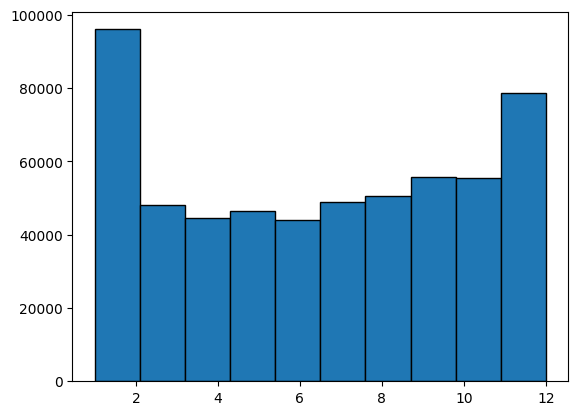

In [39]:
plt.hist(clean_data['month'],edgecolor="black")
plt.show()

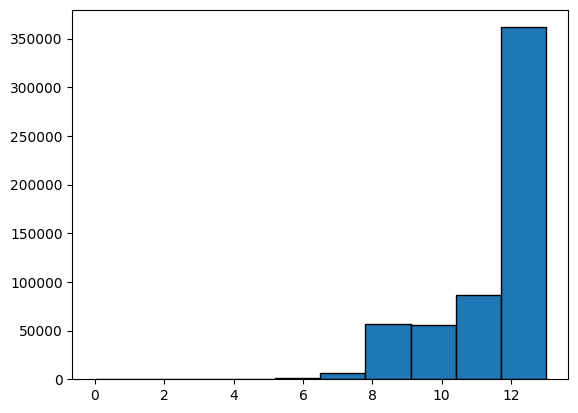

In [40]:
plt.hist(clean_data['year'],edgecolor='black')
plt.show()

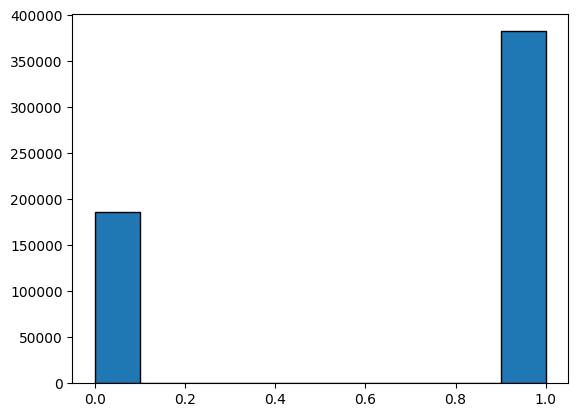

In [41]:
plt.hist(clean_data['hour'],edgecolor='black')
plt.show()

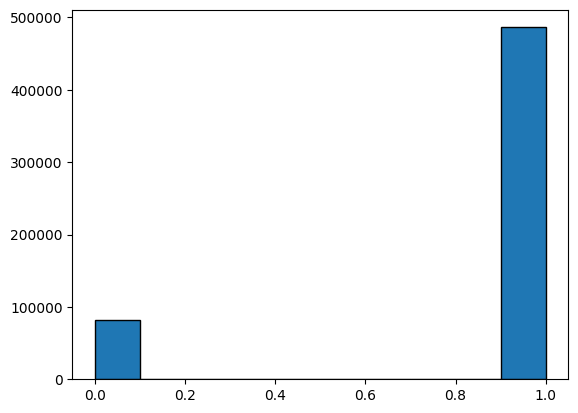

In [42]:
plt.hist(clean_data['Recomended'],edgecolor="black")
plt.show()

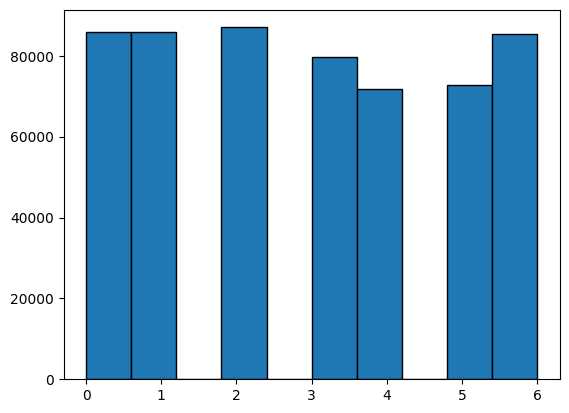

In [43]:
plt.hist(clean_data['day_of_week'],edgecolor="black")
plt.show()

# turn them into torch dataset

In [44]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [45]:
p=torch.tensor(90,dtype=torch.long)

In [46]:
class Mydataset(Dataset):
    def __init__(self,data):
        super().__init__()
        self.data=data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        #element to extract
        item=self.data.iloc[idx]
        
        return {
            "product_id":torch.tensor([item['ProductId']],dtype=torch.long).to(device),
            "user_id":torch.tensor([item['UserId']],dtype=torch.long).to(device) ,
            "year":torch.tensor([item['year']],dtype=torch.long).to(device) ,
            "month":torch.tensor([item['month']],dtype=torch.long).to(device) ,
            "day_of_week":torch.tensor([item['day_of_week']],dtype=torch.long).to(device) ,
            "hour":torch.tensor([item['hour']],dtype=torch.long).to(device) ,
            "recomended":torch.tensor([item['Recomended']],dtype=torch.float).to(device)
        }

## loading the torch dataset format

In [47]:
#trainig dataset
train_dataset=Mydataset(train)
test_dataset=Mydataset(test)

In [48]:
print(train_dataset)
print(test_dataset)

# turning it into torch dataloader

In [49]:
#making the train dataloader
train_dataloader=DataLoader(
    dataset=train_dataset,
    batch_size=32
)

#making test dataloader
test_dataloader=DataLoader(
    dataset=test_dataset,
    batch_size=32
)

In [50]:
# acessing elements of the dataloader
for batch in train_dataloader:
    print(batch['product_id'].shape)
    print(batch['user_id'].shape)
    break

torch.Size([32, 1])
torch.Size([32, 1])


# model package importing

In [51]:
import sys
sys.path.append('C:/Users/nebiy/Documents/recommendation_system/tiny_recommendation/jupyter_notes/trial.py')
from trial import WideDeep,WD_Config

In [52]:
config=WD_Config()
config.num_product=clean_data['ProductId'].nunique()
config.num_users=clean_data['UserId'].nunique() 
config.num_year=clean_data["year"].nunique()
config.num_time_day=clean_data["hour"].nunique()
config.num_month=clean_data['month'].nunique()+1   #since in this column it start from 1
config.num_day_week=clean_data["day_of_week"].nunique()
config.embedding_dim=100

In [53]:
print(config)

WD_Config(num_product=74257, num_users=256042, num_day_week=7, num_month=13, num_time_day=2, num_feature=6, embedding_dim=100, num_year=14)


In [54]:
model=WideDeep(config)

# setup the config of the model

In [55]:
clean_data["day_of_week"].value_counts()

day_of_week
2    87051
1    85986
0    85850
6    85360
3    79679
5    72791
4    71684
Name: count, dtype: int64

In [56]:
# config.num_product=clean_data['ProductId'].nunique()+1
# config.num_users=clean_data['UserId'].nunique() +1
# config.num_year=clean_data["year"].nunique()+1
# config.num_time_day=clean_data["hour"].nunique()+1
# config.num_month=clean_data['month'].nunique()+1
# config.num_day_week=clean_data["day_of_week"].nunique()+1
# config.embedding_dim=100

In [57]:
model=model.to(device)

In [58]:
optim=torch.optim.AdamW(model.parameters(),lr=0.01,weight_decay=0.01)  #the deep component
#loss_fn=torch.nn.BCELoss() 

#bce with logits
loss_fn=nn.BCEWithLogitsLoss()

#lets use different loss calculation
#loss_rn=nn.MSELoss()

# lets debug some stuff with data and model

In [59]:
# lets access 10 elements from one batch
for batch in train_dataloader:
    product_id=batch["product_id"]
    user_id=batch["user_id"]
    year=batch["year"]
    month=batch["month"]
    day_of_week=batch["day_of_week"]
    hour=batch["hour"]
    recomended=batch["recomended"]
    
    print(product_id.size(0))
    print(user_id.shape)
    print(year.shape)
    print(recomended.shape)
    print(month.shape)
    print(year.shape)
    print(day_of_week.shape)
    
    break

32
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])


# train my model

In [60]:
# extraxt one batch 
for batch in train_dataloader:
    one_batch=batch
    break

In [61]:
batches=[]
for idx,batch in enumerate(train_dataloader):
    if(idx<4):
        batches.append(batch)
    else:
        break

In [62]:
#print(model_pred)

In [63]:
writer=SummaryWriter('runs/wide_deep_weights_grads')

In [64]:
#lets start the training
n_epoch=100
for epoch in range(n_epoch):
    for batch in batches:
        #getting the shape right
        product_id=batch['product_id']
        user_id=batch['user_id']
        year=batch['year']
        month=batch['month']
        day_of_week=batch['day_of_week']
        hour=batch['hour']
        recomended=batch['recomended']
    
        #changing the value of the recomended
        recomended=recomended.float()
        
        #feed forward model
        model_pred=model(
            product_id,
            user_id,
            year,
            month,
            day_of_week,
            hour
        )
    
        #print(f"loss at {epoch} epoch : is {model_pred} ")
    
        #calculate the loss
        loss=loss_fn(model_pred,recomended)
        
        #zero grad
        optim.zero_grad()
        loss.backward()
    
        #lets clip the gradient of the module
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        
        optim.step() #update the gradient 

        #lets see the weights
        for name,param in model.named_parameters():
            writer.add_histogram(name,param,epoch)

        #lets see the gradient norm
        total_norm=0
        for param in model.parameters():
            param_norm=param.grad.data.norm(2)
            total_norm+=param_norm.item()**2
        
        total_norm=total_norm**0.5
        writer.add_scalar('gradient norm',total_norm,epoch)


        #lets recoord the loss
        writer.add_scalar('loss/train',loss.item(),epoch)
        
        
        #display the loss every 5 epoch
    if(epoch%10==0):
        print(f"the loss is {loss.item()}")

#lets close the tenosrboard
writer.close()

the loss is 7749.279296875
the loss is 852.3588256835938
the loss is 176.599609375


KeyboardInterrupt: 

# lets debug

## check for nan values in our dataset

In [ ]:
# clean_data.columns

In [ ]:
# print(f"product id: {clean_data['ProductId'].isnull().sum()} ")
# print(f"user id: {clean_data['UserId'].isnull().sum()} ")
# print(f"year : {clean_data['year'].isnull().sum()} ")
# print(f"month: {clean_data['month'].isnull().sum()} ")
# print(f"day of week: {clean_data['day_of_week'].isnull().sum()} ")
# print(f"hour: {clean_data['hour'].isnull().sum()} ")
# print(f"recomended: {clean_data['Recomended'].isnull().sum()} ")

# wide part

In [ ]:
# lin=nn.Linear(2,1)
# a=one_batch['product_id']
# b=one_batch['user_id']

# a=a.float()
# b=b.float()

# #print(a)
# #print(b)
# for i in range(1000):
#     c=lin(torch.cat((a,b),dim=1))
#     if(i%100==0):
#         print(f"epoch is {i} and value is {c} ")

# deep part

In [ ]:
# config.num_product=clean_data['ProductId'].nunique()+1
# config.num_users=clean_data['UserId'].nunique() +1
# config.num_year=clean_data["year"].nunique()+1
# config.num_time_day=clean_data["hour"].nunique()+1
# config.num_month=clean_data['month'].nunique()+1
# config.num_day_week=clean_data["day_of_week"].nunique()+1
# config.embedding_dim=100

In [ ]:
# embed_input.shape

In [ ]:
# em1=nn.Embedding(clean_data['ProductId'].nunique()+1,100)
# em2=nn.Embedding(clean_data['UserId'].nunique()+1,100)
# em3=nn.Embedding(clean_data['year'].nunique()+1,100)
# em4=nn.Embedding(clean_data['hour'].nunique()+1,100)
# em5=nn.Embedding(clean_data['month'].nunique()+1,100)
# em6=nn.Embedding(clean_data['day_of_week'].nunique()+1,100)

# #em6=nn.Embedding(clean_data['Recomended'].nunique()+1,100)
# true_label=one_batch['recomended']

# #lets forward data through it
# em1_embd=em1(one_batch['product_id'])
# em2_embd=em2(one_batch['user_id'])
# em3_embd=em3(one_batch['year'])
# em4_embd=em4(one_batch['hour'])
# em5_embd=em5(one_batch['month'])
# em6_embd=em6(one_batch['day_of_week'])


# #lets concatinate man
# embed_input=torch.cat((
#     em1_embd.view(em1_embd.size(0),-1),
#     em2_embd.view(em2_embd.size(0),-1),
#     em3_embd.view(em3_embd.size(0),-1),
#     em4_embd.view(em4_embd.size(0),-1),
#     em5_embd.view(em5_embd.size(0),-1),
#     em6_embd.view(em6_embd.size(0),-1)
# ),dim=1)

# #model architecture
# l1=nn.Linear(600,800)
# a1=nn.ReLU()

# l2=nn.Linear(800,400)
# a2=nn.ReLU()

# l3=nn.Linear(400,360)
# a3=nn.ReLU()

# l4=nn.Linear(360,1)

# all_model=nn.Sequential(
#     nn.Linear(600,800),
#     nn.ReLU(),
    
#     nn.Linear(800,400),
#     nn.ReLU(),
    
#     nn.Linear(400,200)
# )

# optim=torch.optim.Adam(all_model.parameters())
# loss_fn=nn.BCELoss()


# #lets feed forward through man
# for i in range(1000):
#     out1=l1(embed_input)
#     act=a1(out1)
    
#     out2=l2(act)
#     act2=a2(out2)
    
#     out3=l3(act2)
#     act3=a3(out3)
    
#     out4=l4(out3)

#     out4=torch.sigmoid(out4)

#     loss=loss_fn(out4,true_label)
    
#     if(i%100==0):
#         print(loss.item())

In [ ]:
# true_label.shape